In [5]:
#
# Marching cube table generation
#

import numpy as np;  Np = np.array

In [6]:
def combination(k, ls): # List[T] -> List[List[T]]
    n = len(ls)
    if k == 0: return [[]]
    if n < k:  return [[]]
    if n == k: return [ls]
    ll1 = combination(k - 1, ls[1:])
    ll1 = [[ls[0]] + l for l in ll1]
    ll2 = combination(k, ls[1:])
    return ll1 + ll2


def permutation(ls): # List[T] -> List[List[T]]
    if len(ls) == 0: return [[]]
    result = []
    for i in range(len(ls)):
        for l in permutation(ls[:i] + ls[i+1:]):
            result += [[ls[i]] + l]
    return result


def permutation_k(k, ls): # int, List[T] -> List[List[T]]
    n = len(ls)
    if k == 0: return [[]]
    if n < k : return [[]]

    result = []
    for i in range(n):
        for l in permutation_k(k - 1, ls[:i] + ls[i+1:]):
            result += [[ls[i]] + l]
    return result


combination(3, list(range(4))), \
permutation(list(range(3))), \
permutation_k(2, list(range(4)))

([[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]],
 [[0, 1, 2], [0, 2, 1], [1, 0, 2], [1, 2, 0], [2, 0, 1], [2, 1, 0]],
 [[0, 1],
  [0, 2],
  [0, 3],
  [1, 0],
  [1, 2],
  [1, 3],
  [2, 0],
  [2, 1],
  [2, 3],
  [3, 0],
  [3, 1],
  [3, 2]])

In [7]:
# Gift-wrapping algorithm where we assume all `ps` is in hull
def sort_ccw(ps): # List[float[2]] -> List[int]

    def make_t(p0, p1):
        v = Np(p1) - Np(p0)
        return np.arctan2(v[1], v[0]) 

    def make_dt(t0, p0, p1):
        t1 = make_t(p0, p1)
        dt = np.mod(t1 - t0, 2 * np.pi)
        return dt
    
    ps_ids = list(zip(ps, range(len(ps))))  # List[(float[2], int)]
    result = []

    # pick initial point (the bottom-left one)
    ps_ids = sorted(ps_ids, key=lambda p_id: p_id[0][0])
    ps_ids = sorted(ps_ids, key=lambda p_id: p_id[0][1])    
    p_id_init = ps_ids.pop(0)
    result += [p_id_init[1]]

    # setup state
    p_prev = p_id_init[0]
    t_prev = - np.pi

    while len(ps_ids) > 0:
        # pick next point
        ps_ids = sorted(ps_ids, key=lambda p_id: make_dt(t_prev, p_prev, p_id[0]))
        p_id = ps_ids.pop(0)
        result += [p_id[1]]
        
        # update state
        p = p_id[0]
        t_prev = make_t(p_prev, p)
        p_prev = p

    return result

In [8]:
def find_hull_faces_from_positions(ps, selected): # List[float[3]], List[int] -> List[List[int]]
    result = []
    # find by brute force
    for k in range(3, len(selected) + 1)[::-1]:
        for ii in combination(k, selected):
            # skip if already in result
            if any(map(lambda face: set(ii).issubset(set(face)), result)):
                continue
            
            # check if they live in a plane
            pp = [ps[i] for i in ii]
            p0, p1, p2, *_ = pp
            v1 = p1 - p0
            v2 = p2 - p0
            n = np.cross(v1, v2)
            if not all(map(lambda p: np.abs(np.dot(p - p0, n)) < 1e-3, pp)):
                continue
                
            # sort to ccw face
            m = Np([v1, v2])
            qq = [m @ (p - p0) for p in pp]
            perm = sort_ccw(qq)
            ii = [ii[j] for j in perm]
            
            # check if other points live in a half space (back)
            if all(map(lambda p: np.dot(p - p0, n) < +1e-3, ps)):
                result += [ii]
                
            # check if other points live in a half space (front)
            if all(map(lambda p: np.dot(p - p0, n) > -1e-3, ps)):
                result += [ii[::-1]]

    return result


find_hull_faces_from_positions(
    Np([[0, 0, 0], [1, 0, 0], [0, 0, 0.5], [0, 0.5, 0], [1, 0, 0.5], [1, 0.5, 0]], np.float),
    [2, 3, 4, 5])

[[4, 5, 3, 2]]

In [9]:
def find_hull_faces(verts, marching_cube=False): # List[Vert] -> List[List[int]]
    kCornerPositions = Np([
        [0, 0, 0],
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 1], 
    ])
    
    positions = [None] * len(verts)
    non_corners = []
    for i, (v0, v1) in enumerate(verts):
        positions[i] = (kCornerPositions[v0] + kCornerPositions[v1]) / 2
        if v0 != v1:
            non_corners += [i]

    # Find hull faces (for maching cube, only use non corners)
    selected = non_corners if marching_cube else list(range(len(verts)))
    faces = find_hull_faces_from_positions(positions, selected) 

    if not marching_cube:
        return faces
    
    # For marching cube, filter out faces live in one of cube face
    def is_on_cube_face(p0, p1, p2):
        n = np.cross(p1 - p0, p2 - p0)
        n /= np.linalg.norm(n)
        axis = np.argmax(np.abs(n))
        b0 = np.allclose(np.abs(n[axis]), 1)
        b1 = np.allclose(p0[axis], 0)
        b2 = np.allclose(p0[axis], 1)
        return b0 and (b1 or b2)

    result = []
    for face in faces:
        p0, p1, p2, *_ = [positions[i] for i in face]
        if not is_on_cube_face(p0, p1, p2):
            result += [face]
    return result


# find_hull_faces([(0, 0), (1, 1), (0, 4), (0, 3), (1, 5), (1,2)], marching_cube=True)
find_hull_faces(
    [(3, 3), (4, 4), (6, 6), (0, 3), (0, 4), (2, 3), (2, 6), (3, 7), (4, 5), (5, 6), (6, 7), (7, 4)],
    marching_cube=True), \
find_hull_faces(
    [(3, 3), (4, 4), (6, 6), (0, 3), (0, 4), (2, 3), (2, 6), (3, 7), (4, 5), (5, 6), (6, 7), (7, 4)],
    marching_cube=False)

([[3, 5, 6, 9, 8, 4], [11, 10, 7]],
 [[3, 4, 1, 11, 7, 0],
  [0, 7, 10, 2, 6, 5],
  [8, 9, 2, 10, 11, 1],
  [3, 5, 6, 9, 8, 4],
  [5, 3, 0],
  [1, 4, 8],
  [9, 6, 2],
  [11, 10, 7]])

In [28]:
#
# Indeces of corners and coordinate system
# 
#   7 - 6
#  /|  /|
# 4 - 5 |
# | | | |
# | 3 | 2
# |/  |/
# 0 - 1
# 
# z  y
# | /
# |/
# 0 -- x
# 

def generate_rule_single(pattern, marching_cube=False): # int[8] -> List[List[Vert]]
    # collect corners
    verts = []
    for i, b in enumerate(pattern):
        if b == 0:
            verts += [(i, i)]

    # collect points between corners
    kNeighbors = [
        (0, 1), (1, 2), (2, 3), (0, 3),
        (4, 5), (5, 6), (6, 7), (4, 7),
        (0, 4), (1, 5), (2, 6), (3, 7)]
    for i, ib in enumerate(pattern):
        for j, jb in enumerate(pattern):
            if (i, j) in kNeighbors and ib != jb:
                verts.append((i, j))

    if len(verts) == 0:
        return [], []

    indices = find_hull_faces(verts, marching_cube=marching_cube)
    
    return verts, indices


def generate_rule(marching_cube): # -> Dict[(Pattern, List[List[Vert]])]
    patterns = np.flip(np.stack(np.meshgrid(*([[0, 1]] * 8), indexing='ij'), axis=-1).reshape((-1, 8)), axis=-1)  # int[2^8, 8]
    rule = {}
    for pattern in patterns:
        rule[tuple(pattern)] = generate_rule_single(pattern, marching_cube)
    return rule


generate_rule_single([1, 1, 0, 0, 0, 0, 0, 0], marching_cube=True), \
generate_rule_single([1, 1, 0, 0, 0, 0, 0, 0], marching_cube=False)
# generate_rule_single([0, 0, 0, 1, 1, 0, 1, 0])

(([(2, 2),
   (3, 3),
   (4, 4),
   (5, 5),
   (6, 6),
   (7, 7),
   (0, 3),
   (0, 4),
   (1, 2),
   (1, 5)],
  [[8, 9, 7, 6]]),
 ([(2, 2),
   (3, 3),
   (4, 4),
   (5, 5),
   (6, 6),
   (7, 7),
   (0, 3),
   (0, 4),
   (1, 2),
   (1, 5)],
  [[4, 3, 9, 8, 0],
   [1, 6, 7, 2, 5],
   [0, 1, 5, 4],
   [8, 6, 1, 0],
   [2, 3, 4, 5],
   [7, 9, 3, 2],
   [8, 9, 7, 6]]))

In [29]:
kRule             = generate_rule(marching_cube=False)
kRuleMarchingCube = generate_rule(marching_cube=True)

In [60]:
def map_values(mapping, func):  # Dict[S, T], Callable[T, U] -> Dict[S, U]
    return dict([ (key, func(value)) for key, value in mapping.items() ])


def flatten(ls): # List[List[T]] -> List[T]
    import itertools
    return list(itertools.chain(*ls))

def to_triangles(ls): # List[T] -> List[List[T]]
    n = len(ls)
    assert n >= 3
    return [ [ls[0], ls[i + 1], ls[i + 2]] for i in range(n - 2) ]


def remove_unused_verts(verts, faces):
    import itertools
    used_indices = list(set(itertools.chain(*faces)))
    new_verts = [verts[i] for i in used_indices]
    new_faces = [[used_indices.index(idx) for idx in face] for face in faces]
    return new_verts, new_faces

In [61]:
kRuleTriangle                 = map_values(kRule, lambda vf: (vf[0], flatten(map(to_triangles, vf[1]))))
kRuleMarchingCubeSlim         = map_values(kRuleMarchingCube, lambda vf: remove_unused_verts(*vf))
kRuleMarchingCubeSlimTriangle = map_values(kRuleMarchingCubeSlim, lambda vf: (vf[0], flatten(map(to_triangles, vf[1]))))

In [92]:
# Pack table as in https://web.archive.org/web/20181127124338/http://paulbourke.net/geometry/polygonise/

kEdgeOrder = [
    (0, 1), (1, 2), (2, 3), (0, 3),
    (4, 5), (5, 6), (6, 7), (4, 7),
    (0, 4), (1, 5), (2, 6), (3, 7),
]

def pack_rule():
    rule = kRuleMarchingCubeSlimTriangle
    edge_table = np.empty(2**8, np.uint16)
    face_table = np.ones((2**8, 3 * 6), np.int8) * -1 # max{ #faces } = 6
    for i, (verts, faces) in enumerate(rule.values()):
        es = sum([1 << kEdgeOrder.index(c) for c in verts])
        fs = [kEdgeOrder.index(verts[i]) for i in flatten(faces)]
        edge_table[i] = es
        face_table[i, :len(fs)] = fs
    return edge_table, face_table


# edge_table, face_table = pack_rule()
# with open('../../python-shader-app/misc/marching_cube/src/table_marching_cube_packed.py', 'w') as f:
#     import textwrap
#     edge_data = ','.join(map(str, edge_table))
#     face_data = ',\n'.join(['[' + ','.join([f"{i: >2}" for i in ii]) + ']' for ii in face_table])
#     print('edge_data = [' + edge_data + ']\n', file=f)
#     print('face_data = [\n' + textwrap.indent(face_data, '  ') + '\n]', file=f)

In [32]:
def format_rule(rule):
    entry_template = """\
  {}: (
    {},
    {}
  ),
"""
    inner = ''
    for a, (b, c) in rule.items():
        inner += entry_template.format(a, b, c)
    return 'data = {\n' + inner + '}'


# with open('../../python-shader-app/misc/marching_cube/src/table_marching_cube.py', 'w') as f:
#     f.write(format_rule(kRuleMarchingCubeSlimTriangle))

# with open('../../python-shader-app/misc/marching_cube/src/table_all_faces.py', 'w') as f:
#     f.write(format_rule(kRuleTriangle))

In [23]:
def make_vert(v0, v1, f0, f1, threshold):
    kCornerPositions = Np([
        [0, 0, 0],
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 1], 
    ])

    if v0 == v1:
        return kCornerPositions[v0]

    p0 = kCornerPositions[v0]
    p1 = kCornerPositions[v1]
    p = p0 + (threshold - f0) / (f1 - f0) * (p1 - p0)
    return p        


def to_triangles(ls): # List[T] -> List[List[T]]
    n = len(ls)
    assert n >= 3
    return [ [ls[0], ls[i + 1], ls[i + 2]] for i in range(n - 2) ]


def marching_cube_single(f, threshold): # (float[8], float) -> float[:, 3], int[:, 3]
    pattern = tuple([int(threshold < f[i]) for i in range(8)])
    verts, faces = kRule[pattern]
    
    positions = np.empty((len(verts), 3))
    for i, (v0, v1) in enumerate(verts):
        positions[i] = make_vert(v0, v1, f[v0], f[v1], threshold)

    indices = flatten(map(to_triangles, faces))
    indices = Np(indices, np.int).reshape((-1, 3))
    return positions, indices


marching_cube_single(f=[1, 0, 0, 0, 0, 0, 0, 0], threshold=0.5)
# marching_cube_single(f=[0.5, 1, 1, 1, 1, 1, 1, 1], threshold=0.5)

(array([[1. , 0. , 0. ],
        [1. , 1. , 0. ],
        [0. , 1. , 0. ],
        [0. , 0. , 1. ],
        [1. , 0. , 1. ],
        [1. , 1. , 1. ],
        [0. , 1. , 1. ],
        [0.5, 0. , 0. ],
        [0. , 0.5, 0. ],
        [0. , 0. , 0.5]]),
 array([[7, 8, 2],
        [7, 2, 1],
        [7, 1, 0],
        [4, 3, 9],
        [4, 9, 7],
        [4, 7, 0],
        [2, 8, 9],
        [2, 9, 3],
        [2, 3, 6],
        [0, 1, 5],
        [0, 5, 4],
        [1, 2, 6],
        [1, 6, 5],
        [3, 4, 5],
        [3, 5, 6],
        [9, 8, 7]]))

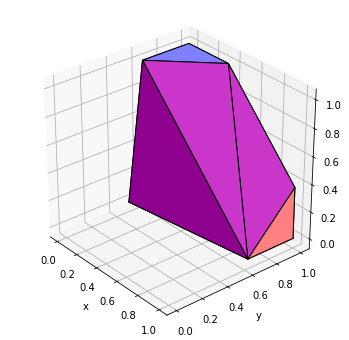

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mpl_toolkits.mplot3d
import ipywidgets as ipyw


def _0(
        f000=0.0,
        f100=0.0,
        f110=0.0,
        f010=0.0,    
        f001=0.0,
        f101=0.0,
        f111=0.0,
        f011=0.0,
        threshold=0.5,
        elev=30, azim=-40, ax=False):

    positions, triangles = marching_cube_single(
            f=[f000, f100, f110, f010, f001, f101, f111, f011], threshold=threshold)

    if ax is False:
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='3d'))
    ax.view_init(elev, azim)    
    lim = [-0.05, 1.05]
    ax.set(xlim=lim, ylim=lim, zlim=lim, xlabel='x', ylabel='y', zlabel='z')
    
    for tri in triangles:
        p012 = positions[tri]
        poly = mpl_toolkits.mplot3d.art3d.Poly3DCollection(p012)
        n = np.cross(p012[1] - p012[0], p012[2] - p012[0])
        n /= np.linalg.norm(n)
        poly.set_color(colors.rgb2hex(0.5 + 0.5 * n)) # shade by normal
        poly.set_edgecolor('k')
        ax.add_collection3d(poly)

_0(1.0, 1.0, 0.2, 0.0, 1.0, 1.0, 1.0, 0.2)

# UI
# ipyw.interact(_0,
#         f000=(0, 1, 0.1),
#         f100=(0, 1, 0.1),
#         f110=(0, 1, 0.1),
#         f010=(0, 1, 0.1),
#         f001=(0, 1, 0.1),
#         f101=(0, 1, 0.1),
#         f111=(0, 1, 0.1),
#         f011=(0, 1, 0.1),              
#         threshold=(0, 1, 0.1),
#         elev=(-90, 90, 10), axim=(-180, 180, 20))

In [230]:
#
# Marching square
#

import numpy as np; Np = np.array
import matplotlib.pyplot as plt
import ipywidgets as ipyw

In [231]:
def make_t(p0, p1):
    v = Np(p1) - Np(p0)
    return np.arctan2(v[1], v[0]) 


def make_dt(t0, p0, p1):
    t1 = make_t(p0, p1)
    dt = np.mod(t1 - t0, 2 * np.pi)
    return dt


def find_min(ls, func):
    result = ls[0]
    result_y = func(result)
    for x in ls[1:]:
        y = func(x)
        if y < result_y:
            result = x
            result_y = y
    return result


# 2d Convex hull (special case where we assume all `ps` will be in hull)
def convex_hull_positions(ps): # List[float[2]] -> List[int]
    ps_ids = list(zip(ps, range(len(ps))))  # List[(float[2], int)]
    result = []

    # pick initial point
    p_id_init = find_min(ps_ids, lambda p_id: p_id[0][0])
    ps_ids.remove(p_id_init)
    result += [p_id_init[1]]

    # setup state
    p_prev = p_id_init[0]
    t_prev = - np.pi

    while len(ps_ids) > 0:
        # pick next point
        p_id = find_min(ps_ids, lambda p_id: make_dt(t_prev, p_prev, p_id[0]))
        ps_ids.remove(p_id)
        result += [p_id[1]]
        
        # update state
        p = p_id[0]
        t_prev = make_t(p_prev, p)
        p_prev = p
        
    return result

In [232]:
def convex_hull_vertices(vs): # List[Vert] -> List[Vert]
    kVertPositions = dict([
        [(0, 0),  [0.0, 0.0]],
        [(1, 1),  [1.0, 0.0]],
        [(2, 2),  [0.0, 1.0]],
        [(3, 3),  [1.0, 1.0]],
        [(0, 1),  [0.5, 0.0]],
        [(0, 2),  [0.0, 0.5]],
        [(1, 3),  [1.0, 0.5]],
        [(2, 3),  [0.5, 1.0]],
    ])
    ps = list(map(lambda v: kVertPositions[v], vs))
    perm = convex_hull_positions(ps)
    vs = list(map(list, Np(vs)[perm])) # apply permutation
    return vs
    
convex_hull_vertices([(2, 3), (0, 0), (3, 3), (0, 2), (1, 1)])

[[0, 0], [1, 1], [3, 3], [2, 3], [0, 2]]

In [233]:
def generate_rule_single(pattern): # -> Optional[List[Vert]]
    # collect verts
    verts = []
    for i in range(4):
        if pattern[i] == 1:
            verts.append((i, i))

    # collect new verts between original verts
    kNeighbors = [(0, 1), (0, 2), (1, 3), (2, 3)]
    for i in range(4):
        for j in range(4):
            if (i, j) in kNeighbors and pattern[i] != pattern[j]: 
                verts.append((i, j))

    if len(verts) == 0:
        return None

    # make convex hull
    return convex_hull_vertices(verts)


def generate_rule(): # -> Dict[(Pattern, List[List[Vert]])]
    patterns = np.stack(np.meshgrid(*([[0, 1]] * 4)), axis=-1).reshape((-1, 4))  # int[2^4, 4]
    rule = {}
    for pattern in patterns:
        rule[tuple(pattern)] = generate_rule_single(pattern)
    return rule

In [234]:
kRule = generate_rule()
kRule

{(0, 0, 0, 0): None,
 (0, 0, 0, 1): [[2, 3], [1, 3], [3, 3]],
 (0, 0, 1, 0): [[2, 2], [0, 2], [2, 3]],
 (0, 0, 1, 1): [[2, 2], [0, 2], [1, 3], [3, 3]],
 (1, 0, 0, 0): [[0, 0], [0, 1], [0, 2]],
 (1, 0, 0, 1): [[0, 0], [0, 1], [1, 3], [3, 3], [2, 3], [0, 2]],
 (1, 0, 1, 0): [[0, 0], [0, 1], [2, 3], [2, 2]],
 (1, 0, 1, 1): [[0, 0], [0, 1], [1, 3], [3, 3], [2, 2]],
 (0, 1, 0, 0): [[0, 1], [1, 1], [1, 3]],
 (0, 1, 0, 1): [[0, 1], [1, 1], [3, 3], [2, 3]],
 (0, 1, 1, 0): [[2, 2], [0, 2], [0, 1], [1, 1], [1, 3], [2, 3]],
 (0, 1, 1, 1): [[2, 2], [0, 2], [0, 1], [1, 1], [3, 3]],
 (1, 1, 0, 0): [[0, 0], [1, 1], [1, 3], [0, 2]],
 (1, 1, 0, 1): [[0, 0], [1, 1], [3, 3], [2, 3], [0, 2]],
 (1, 1, 1, 0): [[0, 0], [1, 1], [1, 3], [2, 3], [2, 2]],
 (1, 1, 1, 1): [[0, 0], [1, 1], [3, 3], [2, 2]]}

In [235]:
def make_vert(v0, v1, f0, f1, threshold):
    kVerts = np.array([
        0, 0,
        1, 0,
        0, 1,
        1, 1,
    ]).reshape((4, 2))
    
    if v0 == v1:
        return kVerts[v0]

    p0 = kVerts[v0]
    p1 = kVerts[v1]
    p = p0 + (threshold - f0) / (f1 - f0) * (p1 - p0)
    return p


def to_triangles(vs): # List[T] -> List[List[T]]
    n = len(vs)
    assert n >= 3
    return [ [vs[0], vs[i + 1], vs[i + 2]] for i in range(n - 2) ]

In [236]:
def marching_square_single(f00, f10, f01, f11, threshold): # List[List[float[2]]]
    pattern = (
        int(threshold < f00),
        int(threshold < f10),
        int(threshold < f01),
        int(threshold < f11))
    face = kRule[pattern]
    if face is None:
        return []

    fs = [f00, f10, f01, f11]
    ls = []
    for v0, v1 in face:
        ls += [make_vert(v0, v1, fs[v0], fs[v1], threshold)]
    return Np(to_triangles(ls))


marching_square_single(f00=0.6, f10=0.4, f01=0.1, f11=1.0, threshold=0.5)

array([[[0.        , 0.        ],
        [0.5       , 0.        ],
        [1.        , 0.16666667]],

       [[0.        , 0.        ],
        [1.        , 0.16666667],
        [1.        , 1.        ]],

       [[0.        , 0.        ],
        [1.        , 1.        ],
        [0.44444444, 1.        ]],

       [[0.        , 0.        ],
        [0.44444444, 1.        ],
        [0.        , 0.2       ]]])

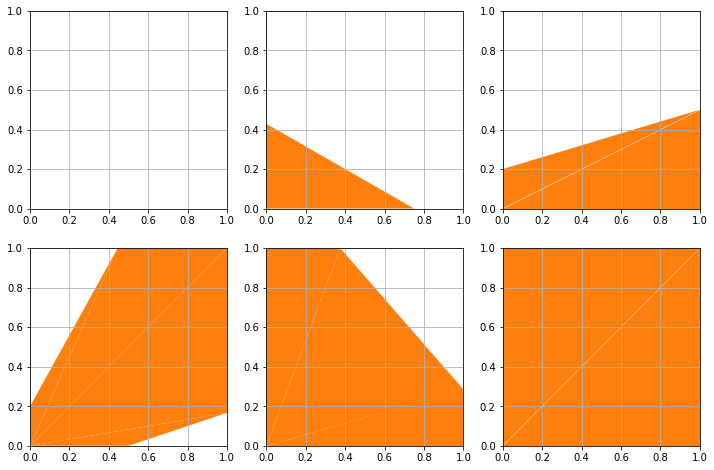

In [237]:
def _0(f00=0.6, f10=0.4, f01=0.1, f11=1.0, threshold=0.5, ax=False):
    triangles = marching_square_single(f00, f10, f01, f11, threshold)

    if not ax:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.set(xlim=[0, 1], ylim=[0, 1])
    ax.grid()
    for triangle in triangles:
        x, y = triangle.T
        ax.fill(x, y, 'C1')


# Show all patterns unique-up-to rotational symmetry
def _1():
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    _0(0.3, 0.4, 0.1, 0.2, ax=axes[0, 0])  # 0000
    _0(0.8, 0.4, 0.1, 0.2, ax=axes[0, 1])  # 1000
    _0(0.6, 0.8, 0.1, 0.2, ax=axes[0, 2])  # 1100
    _0(0.6, 0.4, 0.1, 1.0, ax=axes[1, 0])  # 1001
    _0(0.6, 0.7, 0.8, 0.0, ax=axes[1, 1])  # 1110
    _0(0.6, 0.7, 0.8, 0.9, ax=axes[1, 2])  # 1111        


_1()

# UI
# ipyw.interact(_0, f00=(0, 1, 0.05), f10=(0, 1, 0.05), f01=(0, 1, 0.05), f1=(0, 1, 0.05), threshold=(0, 1, 0.05))